## A recreation of Rodriguez-Ruiz et al.'s model for classifying depression using the depresjon dataset.

### An outline of the pre-processing tasks:

1) Extract all the activity data into a single data frame

2) Crop the data so that each participant has an equal number of activity readings

3) Segment the data into one hour intervals (Summing the data)

4) Split the data into day (8 - 20hrs), night (21 - 7hrs) and full day subsets

5) Remove any missing data

6) Perform a standardisation $z_i = \frac{x_i -\bar x}{s}$

In [2]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt
from scipy.stats import skew

In [3]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


In [4]:
# Extration of all the acitvity data into one data frame
folderpath = '../data/depresjon'
# full ds, no csv
df = extract_from_folder(folderpath)


In [5]:
# print df head
print(df.head())

            timestamp       date  activity         id  label
0 2003-03-18 15:00:00 2003-03-18        60  control_1      0
1 2003-03-18 15:01:00 2003-03-18         0  control_1      0
2 2003-03-18 15:02:00 2003-03-18       264  control_1      0
3 2003-03-18 15:03:00 2003-03-18       662  control_1      0
4 2003-03-18 15:04:00 2003-03-18       293  control_1      0


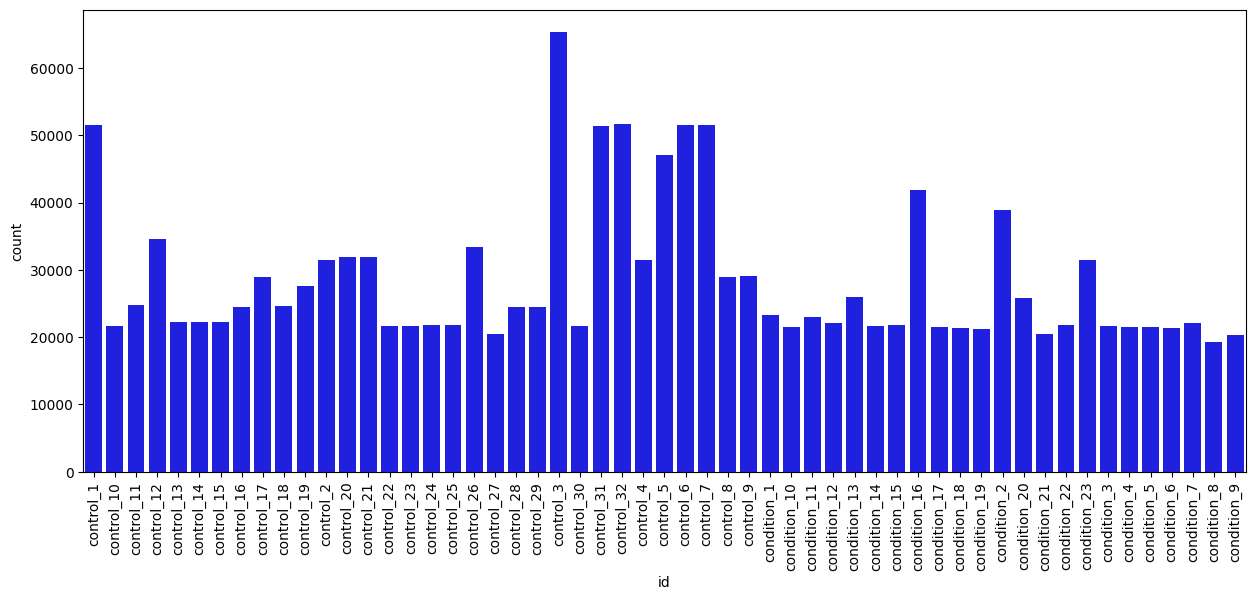

In [6]:
# Plot to show the number of recorded data values for each participant

plt.figure(figsize=(15, 6))

sns.countplot(data = df, x='id', color='blue')
plt.xticks(rotation=90)
plt.show()


In [7]:
# Function to find the minimum number of data values over all participants 

count = df['id'].value_counts()
count.min()

19299

In [8]:
# trimmed df is a dataset with only 19299 activity values for each participant

trimmed_df = df.groupby('id').head(19299)

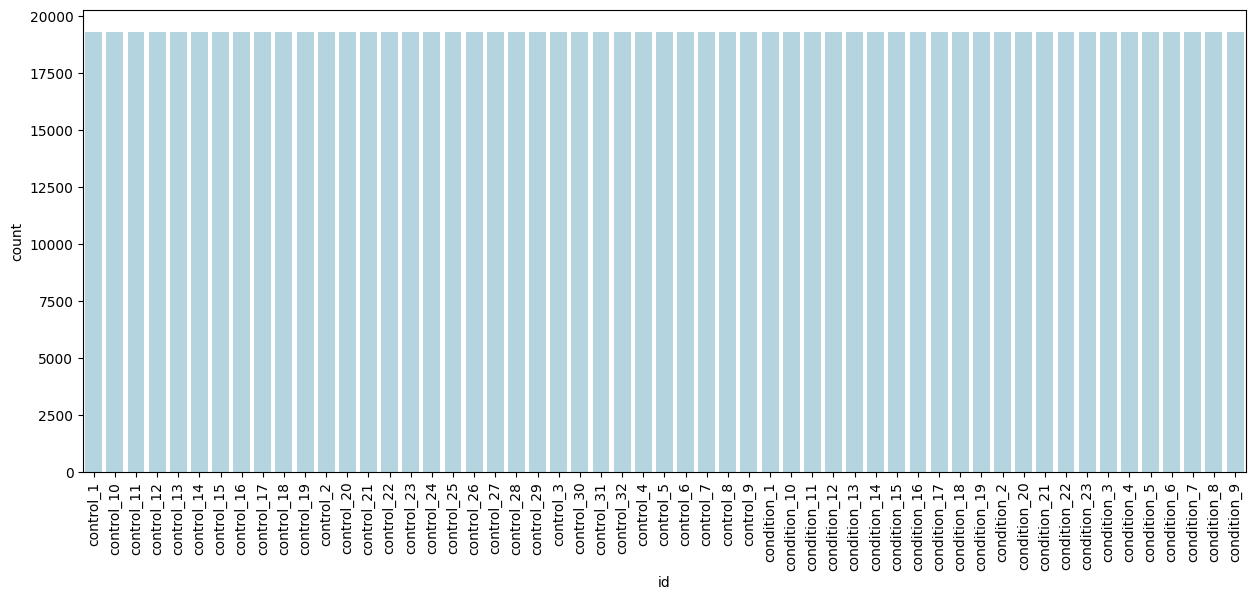

In [9]:
# Plot to check the number of recorded trimmed data values for each participant

plt.figure(figsize=(15, 6))

sns.countplot(data = trimmed_df, x='id', color='lightblue')
plt.xticks(rotation=90)
plt.show()

In [10]:
df['hour'] = trimmed_df['timestamp'].dt.hour
segmented_df = df.groupby(['date','hour','id','label'])['activity'].sum().reset_index()

segmented_df

,date,hour,id,label,activity
0,2002-05-24,11.0,condition_20,1,4359
1,2002-05-24,12.0,condition_20,1,7718
2,2002-05-24,13.0,condition_20,1,8124
3,2002-05-24,14.0,condition_20,1,4321
4,2002-05-24,15.0,condition_20,1,14982
...,...,...,...,...,...
17717,2006-02-12,18.0,control_30,0,26934
17718,2006-02-12,19.0,control_30,0,33631
17719,2006-02-12,20.0,control_30,0,10881
17720,2006-02-12,21.0,control_30,0,17866


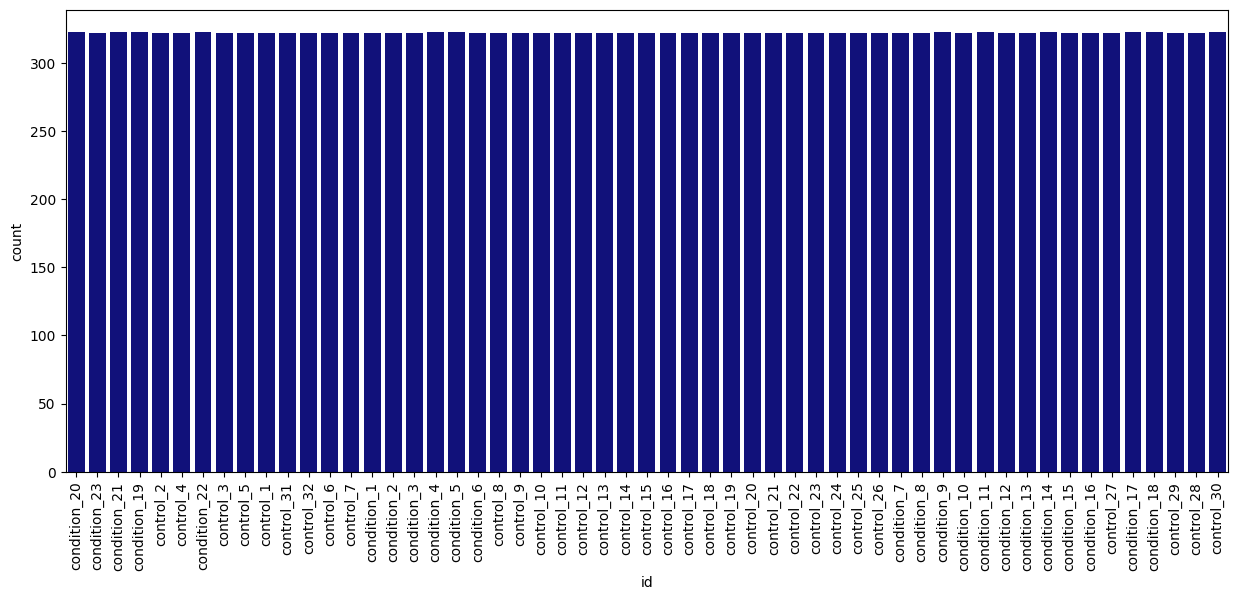

In [11]:
# Plot to check the number of recorded segmented data values for each participant

plt.figure(figsize=(15, 6))

sns.countplot(data = segmented_df, x='id', color='darkblue')
plt.xticks(rotation=90)
plt.show()

In [11]:
# check for null values

segmented_df.isnull().sum()

date        0
hour        0
id          0
label       0
activity    0
dtype: int64

In [12]:
# creation of the 3 datasets

fullday_df = segmented_df.copy()
day_df = segmented_df[(segmented_df['hour'] >= 8) & (segmented_df['hour'] <=20)]
night_df = segmented_df[(segmented_df['hour'] < 8) | (segmented_df['hour'] > 20)]

In [13]:
# Function to find the minimum number of data values for each subset 

print(day_df.shape)
print(night_df.shape)
print(fullday_df.shape)

(9794, 5)
(7928, 5)
(17722, 5)


In [14]:
# Check I haven't dropped any participants

No_Participants = len([segmented_df['id'].unique()][0])
print(No_Participants)

55


### Mistake or a misinterpretation in the article

As you can see from the above result I have created 17722 data values copying the same process set out in the article. My result is a much smaller value compared with the amount (26113) quoted in the article. Under further scrutiny the quoted 26113 could not be created from an even split of the 55 participants as it is not divisable, my conclusion is that the process outlined in the article is not consistent with the results. I will continue to recreate the rest of the article using the smaller datasets and revisit this issue at a later time.

Additionally the article mentioned the removal of null values, which from my above analyses shows there are none. This shows again an inconsistency with the article's descriptions and findings.

In [15]:
# function to create a standardised activity column

def adding_standardised_column(dataframe):
    dataframe.copy()
    avg = dataframe['activity'].mean()
    sd = dataframe['activity'].std()
    dataframe['standardised_activity'] = (dataframe['activity']-avg)/sd
    dataframe.drop('date', axis=1, inplace=True)
    dataframe.drop('hour', axis=1, inplace=True)
    dataframe.drop('activity', axis=1, inplace=True)
    return dataframe

adding_standardised_column(day_df)
adding_standardised_column(night_df)
adding_standardised_column(fullday_df)

C:\Users\44778\AppData\Local\Temp\ipykernel_3672\1499200344.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['standardised_activity'] = (dataframe['activity']-avg)/sd
C:\Users\44778\AppData\Local\Temp\ipykernel_3672\1499200344.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop('date', axis=1, inplace=True)
C:\Users\44778\AppData\Local\Temp\ipykernel_3672\1499200344.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,id,label,standardised_activity
0,condition_20,1,-0.649837
1,condition_20,1,-0.434285
2,condition_20,1,-0.408231
3,condition_20,1,-0.652276
4,condition_20,1,0.031859
...,...,...,...
17717,control_30,0,0.798840
17718,control_30,0,1.228598
17719,control_30,0,-0.231309
17720,control_30,0,0.216931


In [16]:
# check output of the function

print(fullday_df.head())
print(fullday_df.shape)
print()
print(day_df.head())
print(fullday_df.shape)
print()
print(night_df.head())
print(fullday_df.shape)
print()

             id  label  standardised_activity
0  condition_20      1              -0.649837
1  condition_20      1              -0.434285
2  condition_20      1              -0.408231
3  condition_20      1              -0.652276
4  condition_20      1               0.031859
(17722, 3)

             id  label  standardised_activity
0  condition_20      1              -0.977469
1  condition_20      1              -0.771144
2  condition_20      1              -0.746206
3  condition_20      1              -0.979804
4  condition_20      1              -0.324955
(17722, 3)

              id  label  standardised_activity
10  condition_20      1               0.828385
11  condition_20      1              -0.640480
12  condition_20      1              -0.184768
13  condition_20      1              -0.661674
14  condition_20      1              -0.656713
(17722, 3)



### An outline of the feature extraction tasks

1)  Then the following features are extracted before the data is transformed (time-domain):
        
    - Mean
    - Median
    - SD
    - Variance
    - Kurtosis
    - Coefficeint of Variance $\sigma/\mu$
    - IQR
    - Min
    - Max
    - Trimmed Mean (The amount trimmed is not specified so I will use the middle 50% of data)
    
2) Fast fourier transform is applied to create (frequency domain data).
    
3) The same features are extracted as above but also included are:

    - Spectral Density
    - Entropy
    - Skewness
    - Spectral flatness

In [17]:
Participants = list(df['id'].unique())
len(Participants)


55

In [18]:
# create a trimmed mean function

def calculate_trimmed_mean(x):
    q75 = pd.Series(x).quantile(0.75, interpolation='midpoint')  # 75th percentile
    q25 = pd.Series(x).quantile(0.25, interpolation='midpoint')  # 25th percentile
    trimmed_values = x[(x >= q25) & (x <= q75)]  # Select values within the interquartile range (IQR)
    return trimmed_values.mean()

# create a function to produce a table of feature for the time-domain

def extract_TDfeatures(dataframe):
    
    # Group by 'id' and 'label' columns
    grouped = dataframe.groupby(['id', 'label'])['standardised_activity']

    # Calculate statistics for 'standardised_activity' within each group
    features1_df = pd.DataFrame({
        'meanTD' : grouped.mean(),
        'medianTD': grouped.median(),
        'stdTD' : grouped.std(),
        'varianceTD': grouped.var(),
        'kurtosisTD': grouped.apply(pd.DataFrame.kurtosis),
        'coef_of_varTD': grouped.std()/grouped.var(),
        'iqrTD': grouped.quantile(0.75) - grouped.quantile(0.25),
        'minTD': grouped.min(),
        'maxTD': grouped.max(),
        'trimmed_meanTD': grouped.apply(calculate_trimmed_mean)})

    return features1_df


#extract features under the time domain(TD) for each data set

dayTD_features = extract_TDfeatures(day_df)
nightTD_features = extract_TDfeatures(night_df)
fulldayTD_features = extract_TDfeatures(fullday_df)

In [19]:
dayTD_features.head()

,,meanTD,medianTD,stdTD,varianceTD,kurtosisTD,coef_of_varTD,iqrTD,minTD,maxTD,trimmed_meanTD
id,label,,,,,,,,,,
condition_1,1,-0.305921,-0.414328,0.674926,0.455526,6.079701,1.481643,0.707843,-1.245220,2.946278,-0.391206
condition_10,1,0.502722,0.418345,0.830030,0.688949,0.423825,1.204776,1.101621,-1.232505,3.120355,0.417140
condition_11,1,-0.570174,-0.720868,0.686853,0.471767,0.722133,1.455916,1.083593,-1.244728,2.173555,-0.731333
condition_12,1,-0.340854,-0.342830,0.678419,0.460253,1.153743,1.474015,1.065043,-1.245220,2.658872,-0.395744
condition_13,1,0.106599,0.058703,0.702122,0.492975,-0.304467,1.424254,0.974687,-1.192824,2.095607,0.095539


In [20]:
def create_FD(dataframe):
    FD_df = dataframe.copy()
    
    # Perform FFT on 'standardised_activity' column
    FD_df['fft_standardised_activity_complex'] = np.fft.fft(FD_df['standardised_activity'])
    
    # Return only the real values
    FD_df['fft_standardised_activity'] = np.real(FD_df['fft_standardised_activity_complex'])
    
    # drop 'standardised_activity' column
    FD_df.drop('standardised_activity', axis=1, inplace=True)
    FD_df.drop('fft_standardised_activity_complex', axis=1, inplace=True)
    return (FD_df)

fulldayFD_df = create_FD(fullday_df)
dayFD_df = create_FD(day_df)
nightFD_df = create_FD(night_df)

In [21]:
fulldayFD_df

,id,label,fft_standardised_activity
0,condition_20,1,-7.274181e-13
1,condition_20,1,-1.165577e+03
2,condition_20,1,-5.200624e+02
3,condition_20,1,2.931719e+02
4,condition_20,1,-2.337283e+02
...,...,...,...
17717,control_30,0,2.437997e+02
17718,control_30,0,-2.337283e+02
17719,control_30,0,2.931719e+02
17720,control_30,0,-5.200624e+02


In [22]:
def calculate_entropy(spectral_density):
    probability_distribution = spectral_density / np.sum(spectral_density)
    non_zero_probabilities = probability_distribution[probability_distribution != 0]
    entropy = -np.sum(non_zero_probabilities * np.log2(non_zero_probabilities))
    return entropy

def calculate_spectral_flatness(power_spectrum):
    geometric_mean = np.exp(np.mean(np.log(power_spectrum + 1e-20)))  # Adding a small value to avoid log(0)
    arithmetic_mean = np.mean(power_spectrum)
    return geometric_mean / arithmetic_mean

def extract_FDfeatures(dataframe):

    # Group by 'id' and 'label' columns
    grouped = dataframe.groupby(['id', 'label'])['fft_standardised_activity']

    # Calculate statistics for 'fft_standardised_activity' within each group
    features2_df = pd.DataFrame({
        'meanFD': grouped.mean(),
        'medianFD': grouped.median(),
        'stdFD': grouped.std(),
        'varianceFD': grouped.var(),
        'kurtosisFD': grouped.apply(pd.DataFrame.kurtosis),
        'coef_of_varFD': grouped.std() / grouped.mean(),  # Coefficient of variation
        'iqrFD': grouped.apply(lambda x: np.quantile(x, 0.75) - np.quantile(x, 0.25)),
        'minFD': grouped.min(),
        'maxFD': grouped.max(),
        'trimmed_meanFD': grouped.apply(calculate_trimmed_mean),
        'power_spectral_densityFD': grouped.apply(lambda x: np.mean(abs(x) ** 2)),
        'skewnessFD': grouped.apply(skew),
        'entropyFD': grouped.apply(lambda x: calculate_entropy(np.abs(x) ** 2)),
        'spectral_flatnessFD': grouped.apply(lambda x: calculate_spectral_flatness(np.abs(x) ** 2))
    })

    return features2_df

fulldayFD_features = extract_FDfeatures(fulldayFD_df)
dayFD_features = extract_FDfeatures(dayFD_df)
nightFD_features = extract_FDfeatures(nightFD_df)

In [23]:
# create a table of all feature for both time-domain and frequency-domaion data

day_fullfeatures = pd.merge(dayTD_features, dayFD_features, on=['id', 'label'], how='inner').reset_index()
night_fullfeatures = pd.merge(nightTD_features, nightFD_features, on=['id', 'label'], how='inner').reset_index()
fullday_fullfeatures = pd.merge(fulldayTD_features, fulldayFD_features, on=['id', 'label'], how='inner').reset_index()


print(fullday_fullfeatures.shape)
fullday_fullfeatures.head()

(55, 26)


,id,label,meanTD,medianTD,stdTD,varianceTD,kurtosisTD,coef_of_varTD,iqrTD,minTD,...,kurtosisFD,coef_of_varFD,iqrFD,minFD,maxFD,trimmed_meanFD,power_spectral_densityFD,skewnessFD,entropyFD,spectral_flatnessFD
0,condition_1,1,-0.328579,-0.511772,0.683556,0.467249,6.556126,1.462938,0.845383,-0.929562,...,0.036410,89.600209,75.539711,-148.659841,159.166631,-0.458518,3150.113903,0.039744,7.229466,0.226409
1,condition_10,1,0.263614,0.236920,1.041241,1.084182,-0.224857,0.960393,1.829216,-0.921156,...,0.141733,21.703885,76.998072,-163.097758,200.101049,2.278323,3485.447123,0.134396,7.228733,0.276671
2,condition_11,1,-0.381390,-0.655741,0.644953,0.415964,1.559918,1.550501,0.873153,-0.929562,...,-0.026386,22.927683,94.418114,-219.035149,206.908531,5.641970,5389.558229,-0.183561,7.279822,0.271018
3,condition_12,1,-0.265839,-0.480809,0.670260,0.449248,1.685129,1.491959,1.016352,-0.929562,...,1.061024,-35.447208,88.885440,-280.243996,218.268331,-0.471639,5168.299191,-0.143255,7.052470,0.259960
4,condition_13,1,0.089268,0.036897,0.799166,0.638666,-0.515855,1.251305,1.365992,-0.919808,...,0.862721,-10.610631,95.172481,-296.860685,195.829639,-4.203451,5642.379838,-0.431384,7.074593,0.271428


### An outline of the modelling and evaluation tasks

1)  Create the a training datasets for the day subset using the following 9 best features based on time-doamin(T) or frequecy domain (F) data:

- kurtosis (T)
- mean (T)
- median (T)
- min (T)
- trim mean (T)
- median (F)
- SD (F)
- Coefficient of variance (F)
- Spectral Flatness (F)

2)  Create the a training datasets for the night subset using the following 9 best features based on time-doamin(T) or frequecy domain (F) data:

- kurtosis (T)
- median (T)
- IQR (T)
- min (T)
- max (T)
- median (F)
- SD (F)
- Coefficient of variance(F)
- Spectral Flatness (F)


3)  Create the a training datasets for the fullday subset using the following 9 best features based on time-doamin(T) or frequecy domain (F) data:

- kurtosis(T)
- median(T)
- coefficient of variance (T)
- min (T)
- trim mean(T)
- median (F)
- SD (F)
- Coefficient of variance(F)
- Spectral Flatness (F)

4) Run a random forest classifier using the features extracted in a 70% / 30% , train / test ratio.

5) Evaluate the effectiveness using the following measures:

- True Positive
- True negative
- false positive
- false negative
- sensitiveity
- specificity
- predictive value (PPV)
- negative predicted value
- accuracy

In [24]:
# Print a list of all features

listoffeatures = day_fullfeatures.columns
listoffeatures

Index(['id', 'label', 'meanTD', 'medianTD', 'stdTD', 'varianceTD',
       'kurtosisTD', 'coef_of_varTD', 'iqrTD', 'minTD', 'maxTD',
       'trimmed_meanTD', 'meanFD', 'medianFD', 'stdFD', 'varianceFD',
       'kurtosisFD', 'coef_of_varFD', 'iqrFD', 'minFD', 'maxFD',
       'trimmed_meanFD', 'power_spectral_densityFD', 'skewnessFD', 'entropyFD',
       'spectral_flatnessFD'],
      dtype='object')

In [25]:
# Create a list of columns to drop for day

cols_todrop_day = ['id','stdTD','varianceTD',
        'coef_of_varTD', 'iqrTD', 'maxTD',
       'meanFD', 'varianceFD',
       'kurtosisFD', 'iqrFD', 'minFD', 'maxFD',
       'trimmed_meanFD', 'power_spectral_densityFD', 'skewnessFD', 'entropyFD']


# Create the 9 best features dataset for day
day_features = day_fullfeatures.copy()
for column in cols_todrop_day:
    day_features.drop(column, axis=1 , inplace=True)

In [26]:
# Create a list of columns to drop for night
cols_todrop_night = ['id','meanTD', 'stdTD', 'varianceTD',
       'coef_of_varTD',
       'trimmed_meanTD', 'meanFD', 'varianceFD',
       'kurtosisFD', 'iqrFD', 'minFD', 'maxFD',
       'trimmed_meanFD', 'power_spectral_densityFD', 'skewnessFD', 'entropyFD',
       ]

# Create the 9 best features dataset for night
night_features = night_fullfeatures.copy()
for column in cols_todrop_night:
    night_features.drop(column, axis=1 , inplace=True)

In [27]:
# Create a list of columns to drop for fullday
cols_todrop_fullday = ['id','meanTD', 'stdTD', 'varianceTD',
       'iqrTD', 'maxTD',
       'meanFD', 'varianceFD',
       'kurtosisFD', 'iqrFD', 'minFD', 'maxFD',
       'trimmed_meanFD', 'power_spectral_densityFD', 'skewnessFD', 'entropyFD']


# Create the 9 best features dataset for fullday
fullday_features = fullday_fullfeatures.copy()
for column in cols_todrop_fullday:
    fullday_features.drop(column, axis=1 , inplace=True)

In [28]:
print(day_features.head(1))
print(day_features.shape)
print()
print(night_features.head(1))
print(night_features.shape)
print()
print(fullday_features.head(1))
print(fullday_features.shape)
print()

   label    meanTD  medianTD  kurtosisTD    minTD  trimmed_meanTD  medianFD  \
0      1 -0.305921 -0.414328    6.079701 -1.24522       -0.391206 -0.264284   

       stdFD  coef_of_varFD  spectral_flatnessFD  
0  46.319138     -21.256241              0.30358  
(55, 10)

   label  medianTD  kurtosisTD     iqrTD     minTD     maxTD  medianFD  \
0      1 -0.598588     2.59238  0.249433 -0.661674  0.457809 -2.492588   

      stdFD  coef_of_varFD  spectral_flatnessFD  
0  44.71454     -21.569008             0.326757  
(55, 10)

   label  medianTD  kurtosisTD  coef_of_varTD     minTD  trimmed_meanTD  \
0      1 -0.511772    6.556126       1.462938 -0.929562       -0.497012   

   medianFD      stdFD  coef_of_varFD  spectral_flatnessFD  
0 -0.269559  56.209719      89.600209             0.226409  
(55, 10)



In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [51]:
# Creation of random Forest model for day_features

# Create features (X) and targets (y) arrays
Xday = np.array(day_features.drop(columns=['label']))
yday = np.array(day_features['label'])

# Split the data into train and test data in a 70:30 split
Xday_train, Xday_test, yday_train, yday_test = train_test_split(Xday, yday, test_size=0.3, random_state=0)

# Fit the data to the model 
rf_day = RandomForestClassifier()
rf_day.fit(Xday_train, yday_train)
yday_pred = rf.predict(Xday_test)

# Print out metrics
print("performance report on my Random Forst classifier for daytime data\n".format(metrics.classification_report(y_pred, y_test)))
print(metrics.classification_report(yday_pred, yday_test))

performance report on my Random Forst classifier for daytime data

              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.80      0.50      0.62         8

    accuracy                           0.71        17
   macro avg       0.73      0.69      0.69        17
weighted avg       0.73      0.71      0.69        17



In [52]:
# Creation of random Forest model for night_features

# Create features (X) and targets (y) arrays
X_night = np.array(night_features.drop(columns=['label']))
y_night = np.array(night_features['label'])

# Split the data into train and test data in a 70:30 split
Xnight_train, Xnight_test, ynight_train, ynight_test = train_test_split(X_night, y_night, test_size=0.3, random_state=0)

# Fit the data to the model 
rf_night = RandomForestClassifier()
rf_night.fit(Xnight_train, ynight_train)
ynight_pred = rf.predict(Xnight_test)

# Print out metrics
print("performance report on my Random Forst classifier for daytime data\n".format(metrics.classification_report(y_pred, y_test)))
print(metrics.classification_report(ynight_pred, ynight_test))

performance report on my Random Forst classifier for daytime data

              precision    recall  f1-score   support

           0       0.17      1.00      0.29         2
           1       1.00      0.33      0.50        15

    accuracy                           0.41        17
   macro avg       0.58      0.67      0.39        17
weighted avg       0.90      0.41      0.47        17



In [54]:
# Creation of random Forest model for fullday_features

# Create features (X) and targets (y) arrays
Xfullday = np.array(fullday_features.drop(columns=['label']))
yfullday = np.array(fullday_features['label'])

# Split the data into train and test data in a 70:30 split
Xfullday_train, Xfullday_test, yfullday_train, yfullday_test = train_test_split(Xfullday, yfullday, test_size=0.3, random_state=0)

# Fit the data to the model 
rf_fullday = RandomForestClassifier()
rf_fullday.fit(X_train, y_train)
yfullday_pred = rf.predict(Xfullday_test)

# Print out metrics
print("performance report on my Random Forst classifier for daytime data\n".format(metrics.classification_report(y_pred, y_test)))
print(metrics.classification_report(yfullday_pred, yfullday_test))

performance report on my Random Forst classifier for daytime data

              precision    recall  f1-score   support

           0       0.67      0.89      0.76         9
           1       0.80      0.50      0.62         8

    accuracy                           0.71        17
   macro avg       0.73      0.69      0.69        17
weighted avg       0.73      0.71      0.69        17



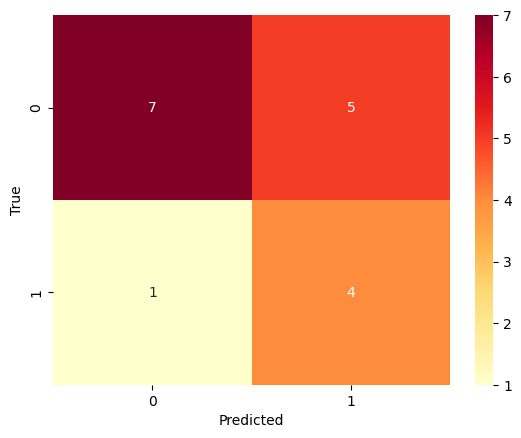

In [61]:
yday_pred2 = rf_day.predict(Xday_test)

conf_matrix = confusion_matrix(yday_test, yday_pred2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

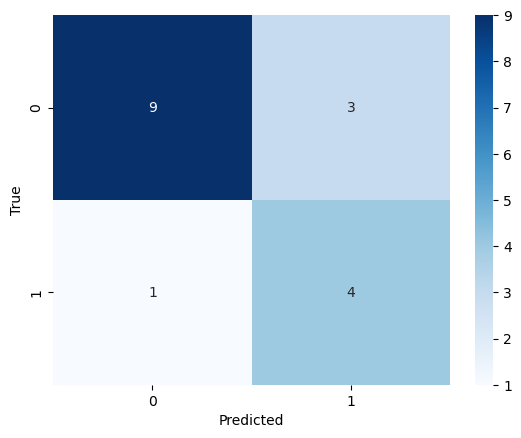

In [63]:
ynight_pred2 = rf_night.predict(Xnight_test)

conf_matrix = confusion_matrix(ynight_test, ynight_pred2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

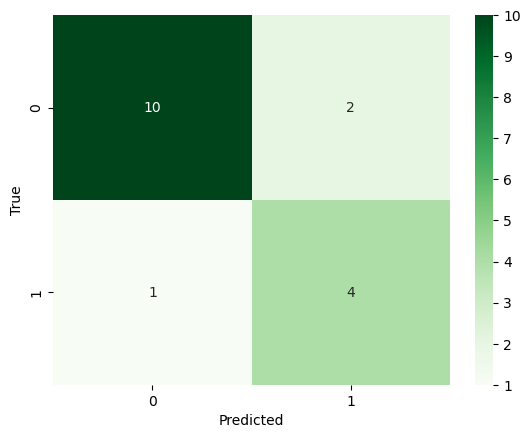

In [70]:
yfullday_pred2 = rf_fullday.predict(Xfullday_test)

conf_matrix = confusion_matrix(yfullday_test, yfullday_pred2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [76]:
def print_metrics(pred,test):
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    true_positive = ((pred == 1) & (test == 1)).sum()
    true_negative = ((pred == 0) & (test == 0)).sum()
    false_positive = ((pred == 1) & (test == 0)).sum()
    false_negative = ((pred == 0) & (test == 1)).sum()

    # Calculate additional metrics
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    ppv = true_positive / (true_positive + false_positive)
    npv = true_negative / (true_negative + false_negative)
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

    # Create a DataFrame
    results_df = pd.DataFrame({
        'Metric': ['True Positive', 'True Negative', 'False Positive', 'False Negative', 
                   'Sensitivity', 'Specificity', 'Predictive Value (PPV)', 
                   'Negative Predicted Value', 'Accuracy'],
        'Value': [true_positive, true_negative, false_positive, false_negative, 
                  sensitivity, specificity, ppv, npv, accuracy]
    })

    # Display the DataFrame
    print("Results from the model:")
    print(results_df)
    
print_metrics(yday_pred2,yday_test)

Results from the model:
                     Metric     Value
0             True Positive  4.000000
1             True Negative  7.000000
2            False Positive  5.000000
3            False Negative  1.000000
4               Sensitivity  0.800000
5               Specificity  0.583333
6    Predictive Value (PPV)  0.444444
7  Negative Predicted Value  0.875000
8                  Accuracy  0.647059


In [77]:
print_metrics(ynight_pred2,ynight_test)

Results from the model:
                     Metric     Value
0             True Positive  4.000000
1             True Negative  9.000000
2            False Positive  3.000000
3            False Negative  1.000000
4               Sensitivity  0.800000
5               Specificity  0.750000
6    Predictive Value (PPV)  0.571429
7  Negative Predicted Value  0.900000
8                  Accuracy  0.764706


In [78]:
print_metrics(yfullday_pred2,yfullday_test)

Results from the model:
                     Metric      Value
0             True Positive   4.000000
1             True Negative  10.000000
2            False Positive   2.000000
3            False Negative   1.000000
4               Sensitivity   0.800000
5               Specificity   0.833333
6    Predictive Value (PPV)   0.666667
7  Negative Predicted Value   0.909091
8                  Accuracy   0.823529
